In [1]:
from pathlib import Path

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import itertools 

from PIL import Image
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import  ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer

### Chargement des données 

In [2]:
# Chargement du DataFrame contenant le chemin d'accès à chaque image et l'espèce correspondante (label)
df = pd.read_csv("V2_Plant_Seedlings_DataFrame.csv")
df.head()

,filepath,species,image_name,height,width,R_mean,G_mean,B_mean,luminosity,sharpness_score,image_size,square
0,C:\Users\zammi\Desktop\DATA_SCIENCE\Projet_ re...,Black-grass,15.png,147,147,86.006109,69.395668,51.121894,68.841224,8.013780,21609,square
1,C:\Users\zammi\Desktop\DATA_SCIENCE\Projet_ re...,Black-grass,88.png,181,181,72.084155,57.116999,42.875004,57.358719,10.732770,32761,square
2,C:\Users\zammi\Desktop\DATA_SCIENCE\Projet_ re...,Black-grass,151.png,638,638,87.168107,68.065462,49.185226,68.139598,127.819102,407044,square
3,C:\Users\zammi\Desktop\DATA_SCIENCE\Projet_ re...,Black-grass,278.png,531,531,90.145336,79.522381,69.335855,79.667857,99.007011,281961,square
4,C:\Users\zammi\Desktop\DATA_SCIENCE\Projet_ re...,Black-grass,182.png,115,115,85.214820,68.097467,47.529301,66.947196,3.812277,13225,square


### Séparation des jeux d'entraînement et de test

In [3]:
# Train/test split: 80% dans le jeu train, 20% dans le jeu test

train_df,test_df = train_test_split(df,
                                    test_size=0.2,
                                    random_state=3,
                                    shuffle=True,
                                    stratify=df['species'])


### Pre-processing

In [4]:
# Définition de la fonction de preprocessing incluant une étape de segmentation par seuillage

def mnv2_preprocessing_with_tsegm(threshold):
    def _mnv2_preprocessing_with_tsegm(input_img):
        # Etape 1: Segmentation simple par seuillage
        img_rgb = np.uint8(input_img)
        img_lab = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2LAB)
        img_lab = cv2.resize(img_lab,(224,224))
        # Création du masque par seuillage
        _,mask = cv2.threshold(img_lab[:,:,1],threshold,255,cv2.THRESH_BINARY_INV)
        # Elimination du bruit par ouverture puis fermeture
        kernel = np.ones((2,2))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        # Application du masque à l'image
        masked_img = cv2.bitwise_and(img_rgb,img_rgb,mask=mask)

        # Etape 2: Preprocessing propre à RestNet50
        final_input = preprocess_input(masked_img)
        return final_input    
    return _mnv2_preprocessing_with_tsegm

In [5]:
# Paramètres de preprocessing

preprocessing_function = mnv2_preprocessing_with_tsegm(threshold=118)
color_mode = 'rgb'
target_size = (224,224)
channels = 3
batch_size = 32

In [6]:
# Instanciation du générateur de données 

# Générateur des données d'entraînement: avec augmentation "faible" des données avec segmentation
train_data_generator = ImageDataGenerator(preprocessing_function= preprocessing_function,
                                          rotation_range=90,
                                          width_shift_range=0.05,
                                          height_shift_range=0.05,
                                          vertical_flip=True,
                                          horizontal_flip=True,
                                          validation_split=0.2) # 20% du jeu train est réservé pour évaluer le modèle au cours de l'entraînement


# Générateur des données de test: avec segmentation et sans augmentation de données 
test_data_generator = ImageDataGenerator(preprocessing_function= preprocessing_function)


In [7]:
# Instanciation des itérateurs associés aux trois jeux train, validation et test

train_iterator = train_data_generator.flow_from_dataframe(train_df,
                                                           x_col='filepath',
                                                           y_col='species',
                                                           target_size=target_size,
                                                           color_mode=color_mode,
                                                           class_mode='sparse',
                                                           batch_size=batch_size,
                                                           subset="training")

validation_iterator = train_data_generator.flow_from_dataframe(train_df,
                                                               x_col='filepath',
                                                               y_col='species',
                                                               target_size=target_size,
                                                               color_mode=color_mode,
                                                               class_mode='sparse',
                                                               batch_size=batch_size,
                                                               subset="validation")

test_iterator = test_data_generator.flow_from_dataframe(test_df,
                                                         x_col='filepath',
                                                         y_col='species',
                                                         target_size=target_size,
                                                         color_mode=color_mode,
                                                         class_mode='sparse',
                                                         batch_size=batch_size,
                                                         shuffle=False)


Found 3545 validated image filenames belonging to 12 classes.
Found 886 validated image filenames belonging to 12 classes.
Found 1108 validated image filenames belonging to 12 classes.


### Construction du modèle, définition des callbacks

In [8]:
# Transfer learning sur la base du modèle RestNet50

# Chargement du modèle de baseRestNet50 pré-entraîné sur la base de données ImageNet

base_model = ResNet50(weights='imagenet',
                      input_shape=(target_size[0],target_size[1],channels), 
                      include_top=False,  # On conserve uniquement la partie convolutionnelle du modèle de base
                      pooling='avg')

base_model.summary()  

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [9]:
# Création du modèle complet: construction fonctionnelle

inputs = Input(shape=(target_size[0],target_size[1],channels),name='Input')
          
# Définition des couches de classification
classif_layer1 = Dropout(rate=0.2,name='Dropout_layer_1')
classif_layer2 = Dense(units=256,activation='relu',name='Dense_layer_1')
classif_layer3 = Dropout(rate=0.2,name='Dropout_layer_2')
classif_layer4 = Dense(units=128,activation='relu',name='Dense_layer_2')
classif_layer5 = Dropout(rate=0.2,name='Dropout_layer_3')
output_layer = Dense(units=12,activation='softmax',name='Dense_layer_output')

# Assemblage du modèle
x = base_model(inputs)
x = classif_layer1(x)
x = classif_layer2(x)
x = classif_layer3(x)
x = classif_layer4(x)
x = classif_layer5(x)
outputs = output_layer(x)

model = Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 Dropout_layer_1 (Dropout)   (None, 2048)              0         
                                                                 
 Dense_layer_1 (Dense)       (None, 256)               524544    
                                                                 
 Dropout_layer_2 (Dropout)   (None, 256)               0         
                                                                 
 Dense_layer_2 (Dense)       (None, 128)               32896     
                                                                 
 Dropout_layer_3 (Dropout)   (None, 128)               0     

In [10]:
# Définition des callbacks 

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                         factor=0.5,
                                         min_delta=0.01,
                                         mode='max',
                                         patience=3,
                                         verbose=1)


# Callback mesurant la durée de l'entraînement
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_train_begin(self, logs={}):
        self.starttime = timer()
    def on_train_end(self, logs={}):
        self.logs.append(timer()-self.starttime)

time_callback = TimingCallback()

In [11]:
# Fonction permettant de charger un éventuel modèle précédemment entraîné, de compiler et de lancer l'entraînement

def model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=None,lr=1.e-3,nb_epochs=30):
    
    # Chargement des poids obtenus lors d'un précédent entraînement
    if loadweights_filepath != None:
        print("Loading model weights")
        model.load_weights(loadweights_filepath)
        
    # Compilation
    print("Compiling model")
    model.compile(optimizer=Adam(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics='accuracy')
    model.optimizer.lr.assign(lr)    # Assignation forcée pour éviter l'utilisation du LR chargé avec les poids (bug Keras?)
    print("Model compilation OK, learning rate =",model.optimizer.lr.numpy())
    
    # Définition du ModelCheckPoint
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       verbose=1)
    
    # Définition du CSV Logger (enregistrement de l'historique d'entraînement)
    csv_logger = CSVLogger(csvlogger_filepath,append=True)
    
    # Entraînement
    print("Launching training")
    training_history = model.fit(train_iterator,validation_data=validation_iterator,
                                 epochs=nb_epochs,
                                 steps_per_epoch=train_iterator.samples//batch_size,
                                 validation_steps=validation_iterator.samples//batch_size,
                                 callbacks=[time_callback,reduce_learning_rate,model_checkpoint,csv_logger],
                                 verbose=True)


### Entraînement du modèle

#### Etape 1: Entraînement avec les poids du modèle de base freezés¶

In [12]:
# Freeze des poids du modèle de base

for layer in base_model.layers:
    layer.trainable = False 

In [13]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','Freeze','best_weights.ckpt')
csvlogger_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','Freeze','training_history.csv')

In [ ]:
# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath)

In [15]:
print("Durée de l'entraînement:",time_callback.logs[0]//60,"minutes.")

Durée de l'entraînement: 63.0 minutes.


In [14]:
# Historique d'entrainement du modéle
training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
training_history.head()

,accuracy,loss,lr,val_accuracy,val_loss
epoch,,,,,
0,0.597210,1.211246,0.001,0.806713,0.537305
1,0.759375,0.659804,0.001,0.849537,0.425634
2,0.799317,0.557273,0.001,0.857639,0.401058
3,0.830629,0.460311,0.001,0.864583,0.393112
4,0.840592,0.445829,0.001,0.885417,0.329149


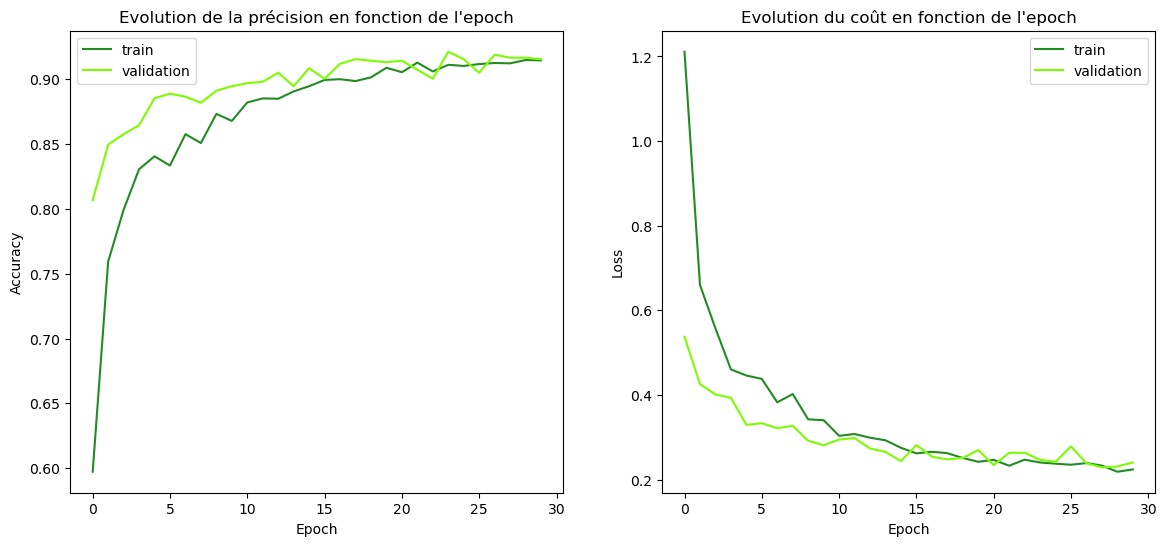

In [15]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement

def plot_history():
    training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    ax[0].plot(training_history['accuracy'], color='forestgreen')
    ax[0].plot(training_history['val_accuracy'], color='lawngreen')
    ax[0].set_title("Evolution de la précision en fonction de l'epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(['train', 'validation'], loc='best');
    ax[1].plot(training_history['loss'], color='forestgreen')
    ax[1].plot(training_history['val_loss'], color='lawngreen')
    ax[1].set_title("Evolution du coût en fonction de l'epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend(['train', 'validation'], loc='best');
    
plot_history()

#### Etape 2: Fine-tuning du modèle par de-freezes successifs du modèle de base et ajustement du learning rate

##### Etape 2.1: De-freeze du 5ème bloc (dernier) du modèle de base

In [16]:
# Identification des couches à dé-freezer

for i,layer in enumerate(base_model.layers):
    print(i,layer.name,"Trainable:",layer.trainable)


0 input_1 Trainable: False
1 conv1_pad Trainable: False
2 conv1_conv Trainable: False
3 conv1_bn Trainable: False
4 conv1_relu Trainable: False
5 pool1_pad Trainable: False
6 pool1_pool Trainable: False
7 conv2_block1_1_conv Trainable: False
8 conv2_block1_1_bn Trainable: False
9 conv2_block1_1_relu Trainable: False
10 conv2_block1_2_conv Trainable: False
11 conv2_block1_2_bn Trainable: False
12 conv2_block1_2_relu Trainable: False
13 conv2_block1_0_conv Trainable: False
14 conv2_block1_3_conv Trainable: False
15 conv2_block1_0_bn Trainable: False
16 conv2_block1_3_bn Trainable: False
17 conv2_block1_add Trainable: False
18 conv2_block1_out Trainable: False
19 conv2_block2_1_conv Trainable: False
20 conv2_block2_1_bn Trainable: False
21 conv2_block2_1_relu Trainable: False
22 conv2_block2_2_conv Trainable: False
23 conv2_block2_2_bn Trainable: False
24 conv2_block2_2_relu Trainable: False
25 conv2_block2_3_conv Trainable: False
26 conv2_block2_3_bn Trainable: False
27 conv2_block2_add 

In [17]:
for layer in base_model.layers[143:]:
    layer.trainable = True

In [18]:
# Définition des paramètres d'entraînement

checkpoint_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','UnFreeze_1','best_weights.ckpt')
csvlogger_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','UnFreeze_1','training_history.csv')
loadweights_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','Freeze','best_weights.ckpt')
lr=1.e-4
nb_epochs=30


In [33]:
# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Loading model weights
Compiling model
Model compilation OK, learning rate = 1e-04
Launching training
Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.4177 - accuracy: 0.8651
Epoch 1: val_accuracy improved from -inf to 0.85417, saving model to Models_training\RestNet50_segment1\no_Freeze_143_no_zoom\best_weights.ckpt
110/110 [==============================] - 151s 1s/step - loss: 0.4177 - accuracy: 0.8651 - val_loss: 0.4277 - val_accuracy: 0.8542 - lr: 1.0000e-04
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.2679 - accuracy: 0.9075
Epoch 2: val_accuracy improved from 0.85417 to 0.90162, saving model to Models_training\RestNet50_segment1\no_Freeze_143_no_zoom\best_weights.ckpt
110/110 [==============================] - 142s 1s/step - loss: 0.2679 - accuracy: 0.9075 - val_loss: 0.2683 - val_accuracy: 0.9016 - lr: 1.0000e-04
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.2280 - accuracy: 0.9140
Epoch 3: val_accuracy 

In [34]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 72.0 minutes.


In [19]:
# Historique d'entrainement du modéle
training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
training_history.head()

,accuracy,loss,lr,val_accuracy,val_loss
epoch,,,,,
0,0.865073,0.417706,0.0001,0.854167,0.427680
1,0.907486,0.267906,0.0001,0.901620,0.268341
2,0.914034,0.227958,0.0001,0.907407,0.266396
3,0.911472,0.232899,0.0001,0.909722,0.275872
4,0.925705,0.203803,0.0001,0.903935,0.287745


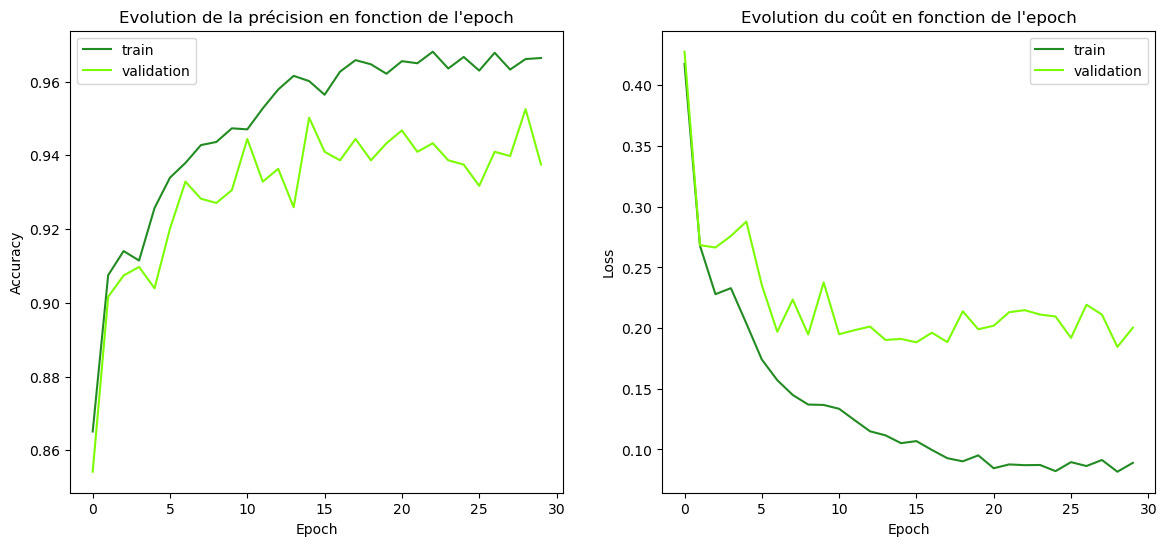

In [20]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

#### Etape 2.2: De-freeze du 4ème bloc du modèle de base

In [21]:
for layer in base_model.layers[81:]:
    layer.trainable = True

In [22]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','UnFreeze_2','best_weights.ckpt')
csvlogger_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','UnFreeze_2','training_history.csv')
loadweights_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','UnFreeze_1','best_weights.ckpt')
lr=1.e-4
nb_epochs=30


In [49]:
# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Loading model weights
Compiling model
Model compilation OK, learning rate = 1e-04
Launching training
Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.2834 - accuracy: 0.9046
Epoch 1: val_accuracy improved from -inf to 0.84028, saving model to Models_training\RestNet50_segment1\no_Freeze_81_no_zoom\best_weights.ckpt
110/110 [==============================] - 237s 2s/step - loss: 0.2834 - accuracy: 0.9046 - val_loss: 0.6218 - val_accuracy: 0.8403 - lr: 1.0000e-04
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.2233 - accuracy: 0.9246
Epoch 2: val_accuracy did not improve from 0.84028
110/110 [==============================] - 227s 2s/step - loss: 0.2233 - accuracy: 0.9246 - val_loss: 0.8371 - val_accuracy: 0.8252 - lr: 1.0000e-04
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.9280
Epoch 3: val_accuracy improved from 0.84028 to 0.85880, saving model to Models_training\RestNet50_segment1\no_Freeze_81

110/110 [==============================] - 233s 2s/step - loss: 0.0523 - accuracy: 0.9798 - val_loss: 0.1802 - val_accuracy: 0.9583 - lr: 3.1250e-06
Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9832
Epoch 25: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 25: val_accuracy did not improve from 0.95833
110/110 [==============================] - 241s 2s/step - loss: 0.0458 - accuracy: 0.9832 - val_loss: 0.1786 - val_accuracy: 0.9514 - lr: 3.1250e-06
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9863
Epoch 26: val_accuracy did not improve from 0.95833
110/110 [==============================] - 243s 2s/step - loss: 0.0376 - accuracy: 0.9863 - val_loss: 0.1884 - val_accuracy: 0.9537 - lr: 1.5625e-06
Epoch 27/30
110/110 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9846
Epoch 27: val_accuracy did not improve from 0.95833
110/110 [====================

In [50]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 119.0 minutes.


In [23]:
# Historique d'entrainement du modéle
training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
training_history.head()

,accuracy,loss,lr,val_accuracy,val_loss
epoch,,,,,
0,0.904640,0.283446,0.0001,0.840278,0.621764
1,0.924566,0.223335,0.0001,0.825231,0.837145
2,0.927982,0.195348,0.0001,0.858796,0.478470
3,0.931398,0.183701,0.0001,0.915509,0.270745
4,0.933390,0.190036,0.0001,0.909722,0.266825


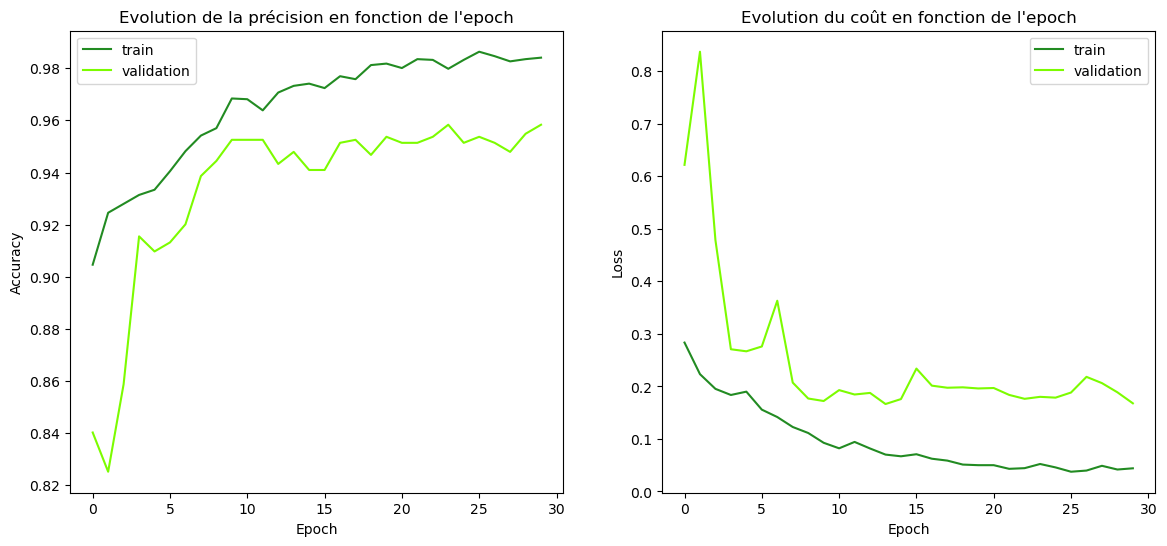

In [24]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

#### Etape 2.3: De-freeze du 3ème bloc du modèle de base

In [25]:
for layer in base_model.layers[39:]:
    layer.trainable = True

In [26]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','UnFreeze_3','best_weights.ckpt')
csvlogger_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','UnFreeze_3','training_history.csv')
loadweights_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','UnFreeze_2','best_weights.ckpt')
lr=1.e-5
nb_epochs=30


In [65]:
# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Loading model weights
Compiling model
Model compilation OK, learning rate = 1e-05
Launching training
Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.9687
Epoch 1: val_accuracy improved from -inf to 0.93287, saving model to Models_training\RestNet50_segment1\no_Freeze_39_no_zoom\best_weights.ckpt
110/110 [==============================] - 391s 4s/step - loss: 0.0790 - accuracy: 0.9687 - val_loss: 0.3427 - val_accuracy: 0.9329 - lr: 1.0000e-05
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.0557 - accuracy: 0.9792
Epoch 2: val_accuracy improved from 0.93287 to 0.94792, saving model to Models_training\RestNet50_segment1\no_Freeze_39_no_zoom\best_weights.ckpt
110/110 [==============================] - 400s 4s/step - loss: 0.0557 - accuracy: 0.9792 - val_loss: 0.2433 - val_accuracy: 0.9479 - lr: 1.0000e-05
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9775
Epoch 3: val_accuracy im

110/110 [==============================] - 387s 4s/step - loss: 0.0395 - accuracy: 0.9841 - val_loss: 0.1928 - val_accuracy: 0.9606 - lr: 1.5625e-07
Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.0355 - accuracy: 0.9863
Epoch 25: val_accuracy did not improve from 0.96412
110/110 [==============================] - 381s 3s/step - loss: 0.0355 - accuracy: 0.9863 - val_loss: 0.1830 - val_accuracy: 0.9630 - lr: 1.5625e-07
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.0378 - accuracy: 0.9846
Epoch 26: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 26: val_accuracy did not improve from 0.96412
110/110 [==============================] - 392s 4s/step - loss: 0.0378 - accuracy: 0.9846 - val_loss: 0.2008 - val_accuracy: 0.9537 - lr: 1.5625e-07
Epoch 27/30
110/110 [==============================] - ETA: 0s - loss: 0.0360 - accuracy: 0.9863
Epoch 27: val_accuracy did not improve from 0.96412
110/110 [====================

In [66]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 192.0 minutes.


In [27]:
# Historique d'entrainement du modéle
training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
training_history.head()

,accuracy,loss,lr,val_accuracy,val_loss
epoch,,,,,
0,0.968688,0.079011,0.00001,0.932870,0.342662
1,0.979220,0.055741,0.00001,0.947917,0.243294
2,0.977512,0.058008,0.00001,0.952546,0.209574
3,0.978366,0.053758,0.00001,0.953704,0.187440
4,0.977797,0.053044,0.00001,0.958333,0.176192


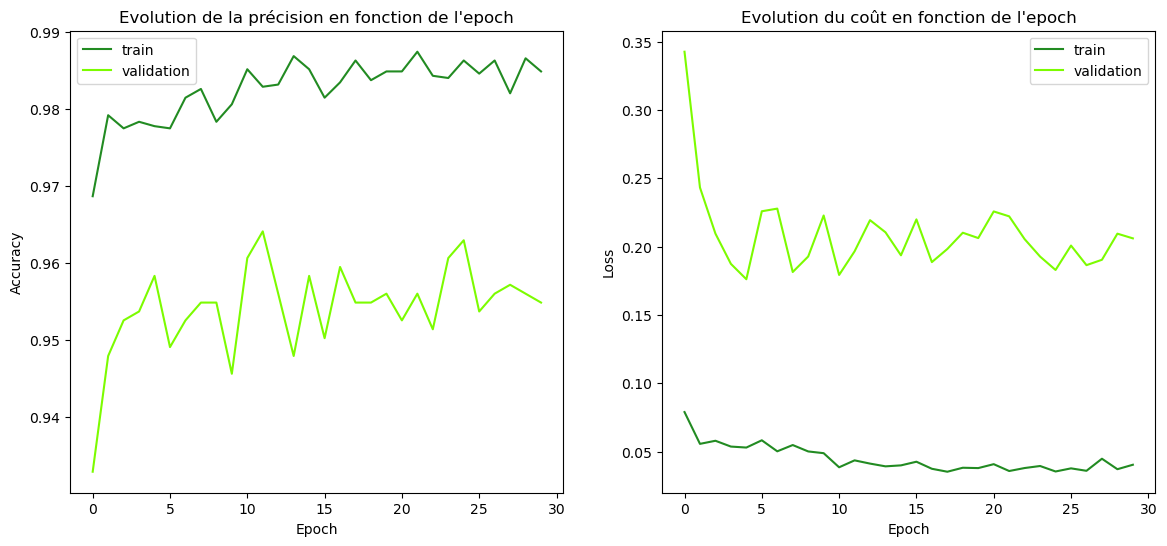

In [28]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

##### Etape 2.4: De-freeze du 2 ème bloc du modèle de base

In [29]:
for layer in base_model.layers[7:]:
    layer.trainable = True

In [30]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','UnFreeze_4','best_weights.ckpt')
csvlogger_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','UnFreeze_4','training_history.csv')
loadweights_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','UnFreeze_3','best_weights.ckpt')
lr=1.e-5
nb_epochs=30


In [81]:
# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Loading model weights
Compiling model
Model compilation OK, learning rate = 1e-05
Launching training
Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9772
Epoch 1: val_accuracy improved from -inf to 0.90278, saving model to Models_training\RestNet50_segment1\no_Freeze_7_no_zoom\best_weights.ckpt
110/110 [==============================] - 524s 5s/step - loss: 0.0623 - accuracy: 0.9772 - val_loss: 0.5532 - val_accuracy: 0.9028 - lr: 1.0000e-05
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9750
Epoch 2: val_accuracy improved from 0.90278 to 0.92940, saving model to Models_training\RestNet50_segment1\no_Freeze_7_no_zoom\best_weights.ckpt
110/110 [==============================] - 473s 4s/step - loss: 0.0601 - accuracy: 0.9750 - val_loss: 0.3655 - val_accuracy: 0.9294 - lr: 1.0000e-05
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9775
Epoch 3: val_accuracy impr

110/110 [==============================] - 492s 4s/step - loss: 0.0366 - accuracy: 0.9869 - val_loss: 0.2066 - val_accuracy: 0.9491 - lr: 1.5625e-07
Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.0364 - accuracy: 0.9880
Epoch 25: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 25: val_accuracy did not improve from 0.96412
110/110 [==============================] - 509s 5s/step - loss: 0.0364 - accuracy: 0.9880 - val_loss: 0.2087 - val_accuracy: 0.9630 - lr: 1.5625e-07
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9846
Epoch 26: val_accuracy did not improve from 0.96412
110/110 [==============================] - 508s 5s/step - loss: 0.0412 - accuracy: 0.9846 - val_loss: 0.2064 - val_accuracy: 0.9618 - lr: 7.8125e-08
Epoch 27/30
110/110 [==============================] - ETA: 0s - loss: 0.0375 - accuracy: 0.9858
Epoch 27: val_accuracy did not improve from 0.96412
110/110 [====================

In [82]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 251.0 minutes.


In [31]:
# Historique d'entrainement du modéle
training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
training_history.head()

,accuracy,loss,lr,val_accuracy,val_loss
epoch,,,,,
0,0.977227,0.062286,0.00001,0.902778,0.553228
1,0.974950,0.060096,0.00001,0.929398,0.365456
2,0.977512,0.060286,0.00001,0.949074,0.243733
3,0.981782,0.048561,0.00001,0.952546,0.252418
4,0.979505,0.057341,0.00001,0.939815,0.233994


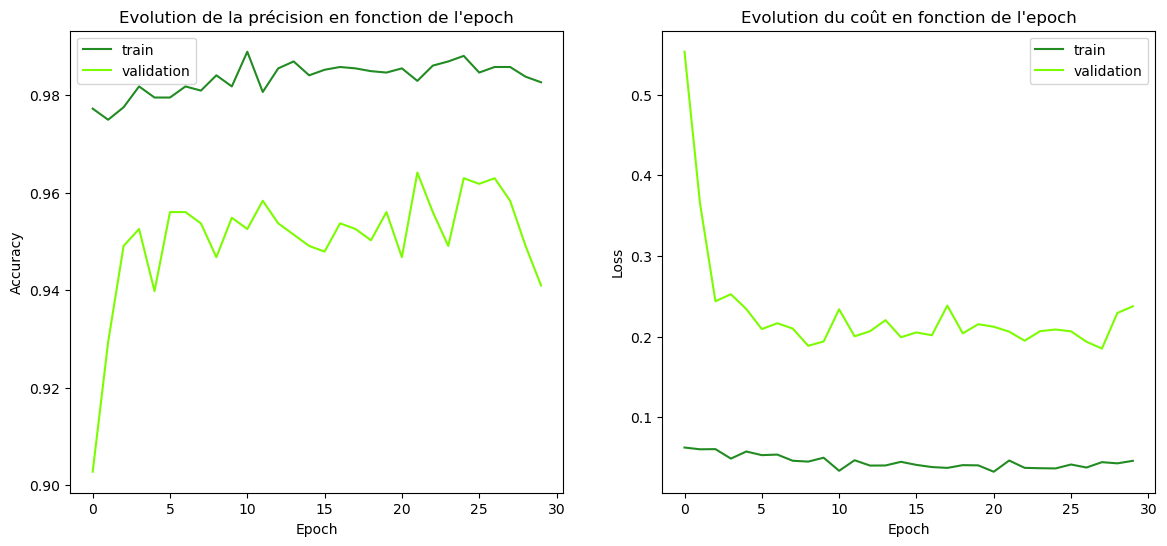

In [32]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

##### Etape 2.5: De-freeze complet du modèle de base

In [33]:
for layer in base_model.layers[:]:
    layer.trainable = True

In [34]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','UnFreeze_5','best_weights.ckpt')
csvlogger_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','UnFreeze_5','training_history.csv')
loadweights_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','UnFreeze_4','best_weights.ckpt')
lr=1.e-5
nb_epochs=30


In [ ]:
# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

In [35]:
# Historique d'entrainement du modéle
training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
training_history.head()

,accuracy,loss,lr,val_accuracy,val_loss
epoch,,,,,
0,0.982067,0.050902,0.00001,0.898148,0.624464
1,0.979789,0.052525,0.00001,0.925926,0.431174
2,0.980643,0.053613,0.00001,0.947917,0.230867
3,0.983775,0.040785,0.00001,0.956019,0.205273
4,0.983490,0.042422,0.00001,0.946759,0.219467


In [98]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 264.0 minutes.


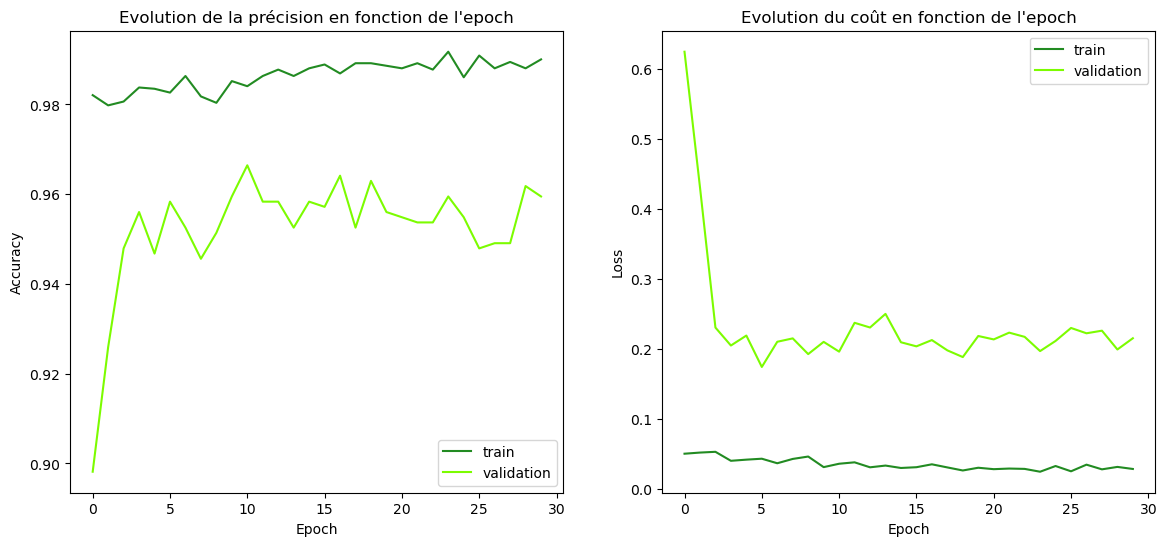

In [36]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

#### Sauvegarde du modèle final (intégralement de-freezé et entraîné) avec les meilleurs poids

In [56]:
# Chargement des meilleurs poids
model.load_weights(Path('Models_training','RestNet50_lowaugm_segmentation','UnFreeze_5','best_weights.ckpt'))

In [53]:
# Sauvegarde au format TensorFlow SavedModel
saving_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','Final_model')
model.save(saving_filepath)

INFO:tensorflow:Assets written to: Models_training\RestNet50_faible_segmentation\Final_model\assets


INFO:tensorflow:Assets written to: Models_training\RestNet50_faible_segmentation\Final_model\assets


#### Analyse de l'entraînement

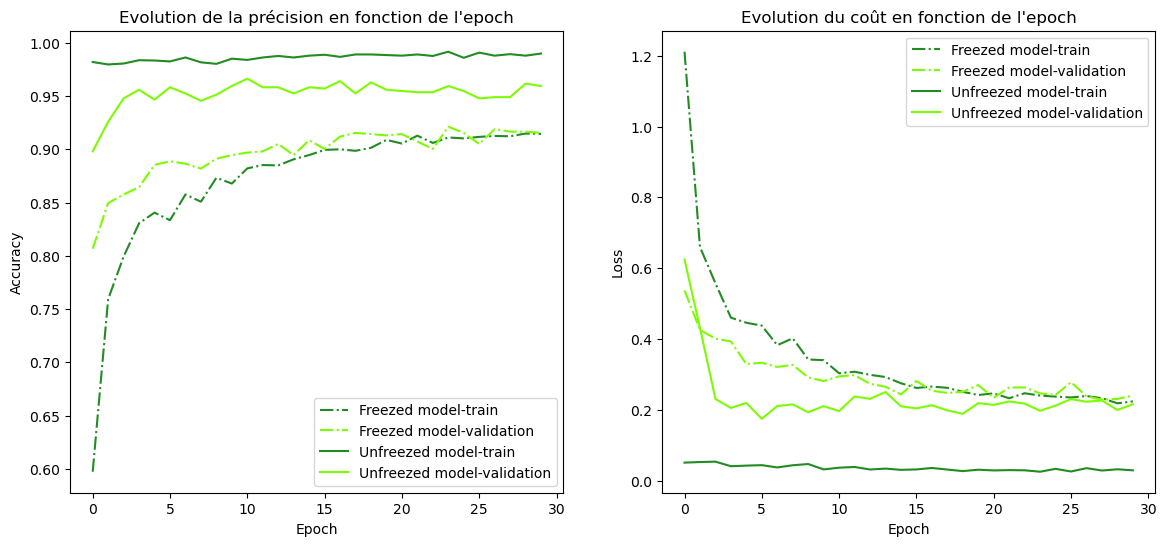

In [35]:
# Visualisation des courbes de convergence de la fonction de coût et de l'accuracy au long de l'entraînement 
# pour le modèle freezé, et pour le modèle intégralemet de-freezé

csvlogger_filepath_freeze = Path('Models_training','RestNet50_lowaugm_segmentation','Freeze','training_history.csv')
csvlogger_filepath_unfreeze = Path('Models_training','RestNet50_lowaugm_segmentation','UnFreeze_5','training_history.csv')


training_history_freeze = pd.read_csv(csvlogger_filepath_freeze,index_col = 'epoch')
training_history_unfreeze = pd.read_csv(csvlogger_filepath_unfreeze,index_col = 'epoch')
    
fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].plot(training_history_freeze['accuracy'],linestyle='-.',color='forestgreen',label="Freezed model-train")
ax[0].plot(training_history_freeze['val_accuracy'],linestyle='-.',color='lawngreen',label="Freezed model-validation")
ax[0].plot(training_history_unfreeze['accuracy'], color='forestgreen',label="Unfreezed model-train")
ax[0].plot(training_history_unfreeze['val_accuracy'], color='lawngreen',label="Unfreezed model-validation")
ax[0].set_title("Evolution de la précision en fonction de l'epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc='best');
ax[1].plot(training_history_freeze['loss'],linestyle='-.',color='forestgreen',label="Freezed model-train")
ax[1].plot(training_history_freeze['val_loss'],linestyle='-.',color='lawngreen',label="Freezed model-validation")
ax[1].plot(training_history_unfreeze['loss'],color='forestgreen',label="Unfreezed model-train")
ax[1].plot(training_history_unfreeze['val_loss'],color='lawngreen',label="Unfreezed model-validation")
ax[1].set_title("Evolution du coût en fonction de l'epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(loc='best');
    

In [36]:
# Visualisation des courbes de dé-freezage

# Récupération des valeurs de loss et accuracy pour le modèle freezé et les de-freezes successifs
loss=[]
accuracy=[]
val_loss=[]
val_accuracy=[]

# Modèle freezé
loadweights_filepath = Path('Models_training','RestNet50_lowaugm_segmentation','Freeze','best_weights.ckpt')
print("Loading model weights - Freeze")
model.load_weights(loadweights_filepath)
print("Compiling model")
model.compile(optimizer=Adam(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics='accuracy')
print("Evaluating model")
train_res = model.evaluate(train_iterator)
loss.append(train_res[0])
accuracy.append(train_res[1])
val_res = model.evaluate(validation_iterator)
val_loss.append(val_res[0])
val_accuracy.append(val_res[1])

# De-freezes successifs
nb_defreeze = 5
for k in range(nb_defreeze):
    directory = "UnFreeze_"+str(k+1)
    loadweights_filepath = Path('Models_training','RestNet50_lowaugm_segmentation',directory,'best_weights.ckpt')
    print("Loading model weights - Unfreeze",str(k+1))
    model.load_weights(loadweights_filepath)
    print("Compiling model")
    model.compile(optimizer=Adam(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics='accuracy')
    print("Evaluating model")
    train_res = model.evaluate(train_iterator)
    loss.append(train_res[0])
    accuracy.append(train_res[1])
    val_res = model.evaluate(validation_iterator)
    val_loss.append(val_res[0])
    val_accuracy.append(val_res[1])

Loading model weights - Freeze
Compiling model
Evaluating model
28/28 [==============================] - 26s 920ms/step - loss: 0.2450 - accuracy: 0.9041
Loading model weights - Unfreeze 1
Compiling model
Evaluating model
28/28 [==============================] - 26s 918ms/step - loss: 0.1885 - accuracy: 0.9413
Loading model weights - Unfreeze 2
Compiling model
Evaluating model
28/28 [==============================] - 26s 933ms/step - loss: 0.1793 - accuracy: 0.9594
Loading model weights - Unfreeze 3
Compiling model
Evaluating model
28/28 [==============================] - 26s 931ms/step - loss: 0.2135 - accuracy: 0.9515
Loading model weights - Unfreeze 4
Compiling model
Evaluating model
28/28 [==============================] - 26s 910ms/step - loss: 0.2239 - accuracy: 0.9492
Loading model weights - Unfreeze 5
Compiling model
Evaluating model
28/28 [==============================] - 26s 929ms/step - loss: 0.2017 - accuracy: 0.9549


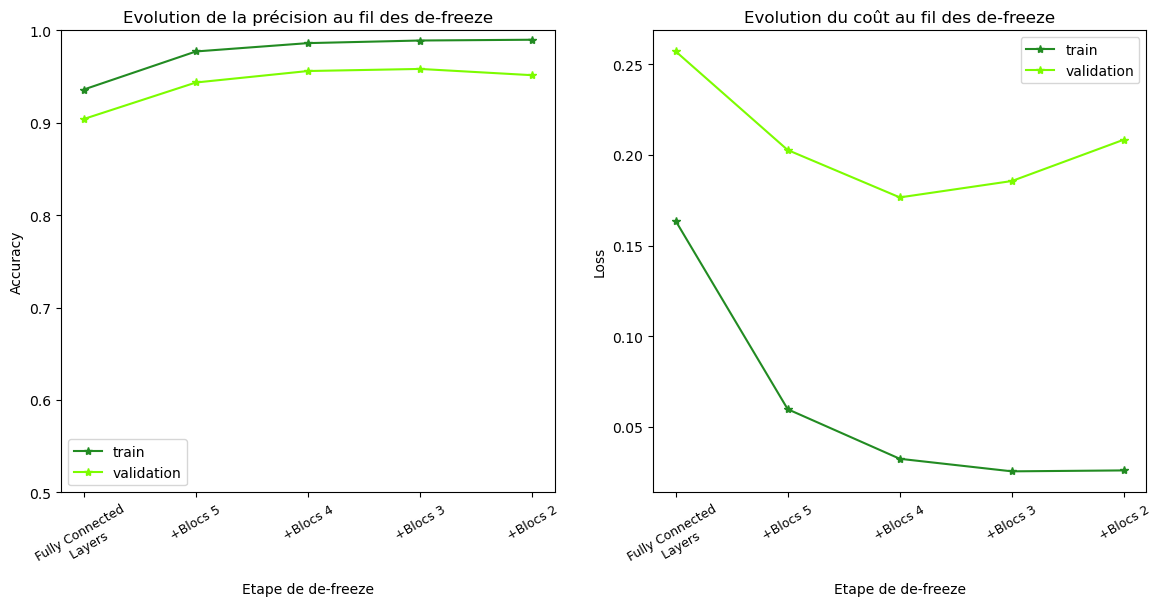

In [52]:
# Tracé des courbes de de-freeze

fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].plot(accuracy, color='forestgreen', marker = "*")
ax[0].plot(val_accuracy, color='lawngreen', marker = "*")
ax[0].set_title("Evolution de la précision au fil des de-freeze")
ax[0].set_xlabel("Etape de de-freeze")
ax[0].set_ylabel("Accuracy")
xticklabels=["Fully Connected\n Layers", "+Blocs 5", "+Blocs 4", "+Blocs 3", "+Blocs 2","+Blocs 1"]
ax[0].set_xticks(range(6))
ax[0].set_xticklabels(xticklabels, rotation=30, fontsize=9)
ax[0].set_ylim(0.5,1)
ax[0].legend(['train', 'validation'], loc='best');
ax[1].plot(loss, color='forestgreen', marker = "*")
ax[1].plot(val_loss, color='lawngreen', marker = "*")
ax[1].set_title("Evolution du coût au fil des de-freeze")
ax[1].set_xlabel("Etape de de-freeze")
ax[1].set_ylabel("Loss")
ax[1].set_xticks(range(6))
ax[1].set_xticklabels(xticklabels, rotation=30, fontsize=9)
ax[1].legend(['train', 'validation'], loc='best');

### Evaluation du modèle

In [59]:
# Chargement du modèle final
model = load_model(saving_filepath)
model.compile(optimizer= Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [60]:
# Evaluation sur les jeux train, validation et test
res = pd.DataFrame(index=['train','validation','test'],columns=['loss','accuracy'])
res.iloc[0,:] = model.evaluate(train_iterator)
res.iloc[1,:] = model.evaluate(validation_iterator)
res.iloc[2,:] = model.evaluate(test_iterator)

saving_filepath_evalu = Path('Models_training','RestNet50_lowaugm_segmentation','RestNet50_lowaugm_segmentation_results.csv')

# Sauvegarde dans un fichier CSV
res.to_csv(saving_filepath_evalu)

35/35 [==============================] - 27s 777ms/step - loss: 0.1573 - accuracy: 0.9531


In [61]:
res

,loss,accuracy
train,0.02241,0.990973
validation,0.217032,0.951467
test,0.157307,0.953069


35/35 [==============================] - 28s 774ms/step
                           precision    recall  f1-score   support

              Black-grass       0.70      0.61      0.66        62
                 Charlock       1.00      1.00      1.00        90
                 Cleavers       0.98      0.97      0.98        67
         Common Chickweed       0.98      1.00      0.99       143
             Common wheat       0.91      0.96      0.93        51
                  Fat Hen       0.99      0.97      0.98       108
         Loose Silky-bent       0.85      0.91      0.88       152
                    Maize       1.00      0.98      0.99        51
        Scentless Mayweed       1.00      0.98      0.99       121
           Sheperds Purse       0.98      1.00      0.99        55
Small-flowered Cranesbill       1.00      0.99      1.00       115
               Sugar beet       1.00      0.97      0.98        93

                 accuracy                           0.95      1108
    

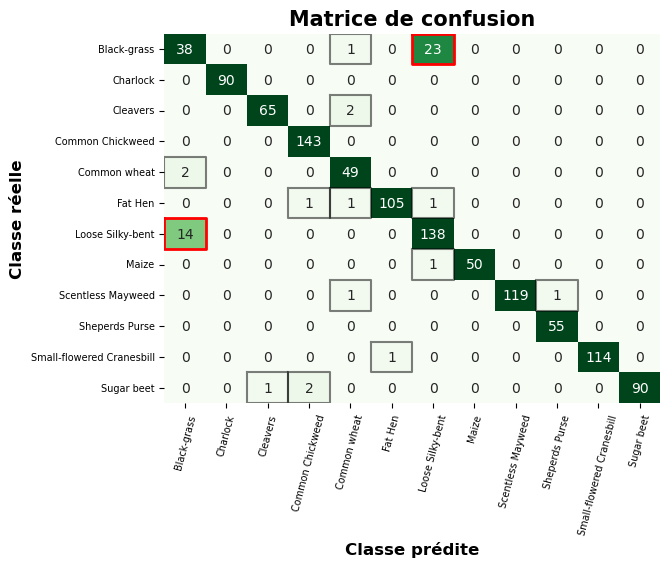

In [62]:
# Rapport de classification & matrice de confusion

def show_metrics():
    y_true = test_iterator.classes
    y_pred = model.predict(test_iterator).argmax(axis=-1)

    print(classification_report(y_true, y_pred, target_names = test_iterator.class_indices.keys()))
    
    matrix = confusion_matrix(y_true, y_pred)
    classes = test_iterator.class_indices.keys()
    sns.heatmap(matrix, annot=True,cmap="Greens", fmt = 'd',vmin=0,vmax=30,cbar=False)
    tick_marks = np.arange(0.5, len(classes), 1)
    plt.xticks(tick_marks, classes, rotation=75, fontsize = 7)
    plt.yticks(tick_marks, classes, rotation=0, fontsize = 7)
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if (i!=j) and (matrix[i,j] !=0):
            if (matrix[i,j] > matrix.mean()):
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="red", linewidth=2)
            else:
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="k", alpha = 0.5)
    plt.ylabel("Classe réelle", fontweight = 'bold', fontsize = 12)
    plt.xlabel("Classe prédite", fontweight = 'bold', fontsize = 12)
    plt.title("Matrice de confusion", fontweight = 'extra bold', fontsize = 15);

show_metrics()